### Introduction:
Object detection is the process of recognizing and locating objects, like football players, within an image or video by drawing bounding boxes around them. Object tracking extends this by following these detected objects across multiple frames, ensuring the same objects are continuously identified as they move. Together, detection finds the objects, while tracking ensures they are consistently monitored throughout a video.

### Objective:
The aim of this project is to implement and compare two state-of-the-art object detection architectures—YOLOv8 and Real-Time Detection Transformer (DETR)—in detecting and tracking football players during live matches. By evaluating the performance of each model in terms of accuracy, speed, and robustness in real-world scenarios, the project seeks to highlight the strengths and weaknesses of both CNN-based and hybrid CNN-Transformer approaches to object detection and tracking.

### YOLOv8:
**Architecture**: YOLOv8 is a purely CNN-based architecture, evolving from earlier YOLO versions to offer faster and more accurate object detection. It divides the image into grids, with each cell responsible for detecting objects within that region, predicting bounding boxes, object classes, and confidence scores.

### Real-Time Detection Transformer (DETR):
**Architecture**: DETR combines CNNs with Transformers, where the CNN extracts feature maps, and the Transformer handles object detection by learning relationships between objects. It uses self-attention mechanisms to identify objects globally without needing grid-based detection like YOLO.


### Install dependencies

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q git+https://github.com/roboflow/supervision.git
!pip install -q accelerate
!pip install -q roboflow
!pip install -q torchmetrics
!pip install -q "albumentations>=1.4.5"

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 40.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 25.6 MB/s eta 0:00:00


### Imports

In [ ]:
import torch
import requests

import numpy as np
import supervision as sv
import albumentations as A

from PIL import Image
from pprint import pprint
from roboflow import Roboflow
from dataclasses import dataclass, replace
from google.colab import userdata
from torch.utils.data import Dataset
from transformers import (
    AutoImageProcessor,
    AutoModelForObjectDetection,
    TrainingArguments,
    Trainer
)
from torchmetrics.detection.mean_ap import MeanAveragePrecision

## Load model

In [ ]:

CHECKPOINT = "PekingU/rtdetr_r50vd_coco_o365"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForObjectDetection.from_pretrained(CHECKPOINT).to(DEVICE)
processor = AutoImageProcessor.from_pretrained (CHECKPOINT)


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

## Fine-tune RT-DETR on custom dataset

In [ ]:
# Download dataset from Roboflow Universe
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="PlqaJHyHNrAmOPchFBiO")
project = rf.workspace("obj-detection-kimlq").project("football-players-detection-3zvbc-sf9bu")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-1 in coco:: 100%|██████████| 320/320 [00:00<00:00, 1747.82it/s]


In [ ]:
ds_train = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
)
ds_valid = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
)
ds_test = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

print(f"Number of training images: {len(ds_train)}")
print(f"Number of validation images: {len(ds_valid)}")
print(f"Number of test images: {len(ds_test)}")

Number of training images: 250
Number of validation images: 43
Number of test images: 19


### Preprocess the data

To finetune a model, we must preprocess the data you plan to use to match precisely the approach used for the pre-trained model. AutoImageProcessor takes care of processing image data to create `pixel_values`, `pixel_mask`, and `labels` that a DETR model can train with.

In [ ]:
IMAGE_SIZE = 480

processor = AutoImageProcessor.from_pretrained(
    CHECKPOINT,
    do_resize=True,
    size={"width": IMAGE_SIZE, "height": IMAGE_SIZE},
)

Before passing the images to the `processor`, apply two preprocessing transformations to the dataset:

- Augmenting images
- Reformatting annotations to meet RT-DETR expectations

First, to make sure the model does not overfit on the training data, we can apply image augmentation with any data augmentation library. Here we use [Albumentations](https://albumentations.ai/docs/). This library ensures that transformations affect the image and update the bounding boxes accordingly.

In [ ]:
#Augmenting images
train_augmentation_and_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=25
    ),
)

valid_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(
        format="pascal_voc",
        label_fields=["category"],
        clip=True,
        min_area=1
    ),
)

In [ ]:
#Reformatting annotations to meet RT-DETR expectations

class PyTorchDetectionDataset(Dataset):
    def __init__(self, dataset: sv.DetectionDataset, processor, transform: A.Compose = None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    @staticmethod
    def annotations_as_coco(image_id, categories, boxes):
        annotations = []
        for category, bbox in zip(categories, boxes):
            x1, y1, x2, y2 = bbox
            formatted_annotation = {
                "image_id": image_id,
                "category_id": category,
                "bbox": [x1, y1, x2 - x1, y2 - y1],
                "iscrowd": 0,
                "area": (x2 - x1) * (y2 - y1),
            }
            annotations.append(formatted_annotation)

        return {
            "image_id": image_id,
            "annotations": annotations,
        }

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, image, annotations = self.dataset[idx]

        # Convert image to RGB numpy array
        image = image[:, :, ::-1]
        boxes = annotations.xyxy
        categories = annotations.class_id

        if self.transform:
            transformed = self.transform(
                image=image,
                bboxes=boxes,
                category=categories
            )
            image = transformed["image"]
            boxes = transformed["bboxes"]
            categories = transformed["category"]


        formatted_annotations = self.annotations_as_coco(
            image_id=idx, categories=categories, boxes=boxes)
        result = self.processor(
            images=image, annotations=formatted_annotations, return_tensors="pt")

        # Image processor expands batch dimension, lets squeeze it
        result = {k: v[0] for k, v in result.items()}

        return result

In [ ]:
pytorch_dataset_train = PyTorchDetectionDataset(
    ds_train, processor, transform=train_augmentation_and_transform)
pytorch_dataset_valid = PyTorchDetectionDataset(
    ds_valid, processor, transform=valid_transform)
pytorch_dataset_test = PyTorchDetectionDataset(
    ds_test, processor, transform=valid_transform)

#pytorch_dataset_train[15]

In [ ]:
def collate_fn(batch):
    data = {}
    data["pixel_values"] = torch.stack([x["pixel_values"] for x in batch])
    data["labels"] = [x["labels"] for x in batch]
    return data

## Preparing function to compute mAP

In [ ]:
id2label = {id: label for id, label in enumerate(ds_train.classes)}
label2id = {label: id for id, label in enumerate(ds_train.classes)}


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, (height, width) in zip(target_batch, image_size_batch):
                boxes = target["boxes"]
                boxes = sv.xcycwh_to_xyxy(boxes)
                boxes = boxes * np.array([width, height, width, height])
                boxes = torch.tensor(boxes)
                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        # Replace list of per class metrics with separate metric for each class
        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=processor, threshold=0.01, id2label=id2label)

## Training the detection model



In [ ]:
model = AutoModelForObjectDetection.from_pretrained(
    CHECKPOINT,
    id2label=id2label,
    label2id=label2id,
    anchor_image_size=None,
    ignore_mismatched_sizes=True,
)

Some weights of RTDetrForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_r50vd_coco_o365 and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([5]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- model.

In [ ]:
training_args = TrainingArguments(
    output_dir=f"{dataset.name.replace(' ', '-')}-finetune",
    num_train_epochs=60,
    max_grad_norm=0.1,
    learning_rate=5e-5,
    warmup_steps=4,
    per_device_train_batch_size=16,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    metric_for_best_model="eval_map",
    greater_is_better=True,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    remove_unused_columns=False,
    eval_do_concat_batches=False,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=pytorch_dataset_train,
    eval_dataset=pytorch_dataset_valid,
    tokenizer=processor,
    data_collator=collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Football-players-detection,Mar 100 Football-players-detection,Map Ball,Mar 100 Ball,Map Goalkeeper,Mar 100 Goalkeeper,Map Player,Mar 100 Player,Map Referee,Mar 100 Referee
1,No log,21.162659,0.057400,0.094800,0.061300,0.057800,-1.000000,-1.000000,0.018000,0.105200,0.210400,0.210400,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.001000,0.193300,0.215100,0.383600,0.013300,0.264500
2,No log,14.228237,0.096600,0.150200,0.109300,0.096800,-1.000000,-1.000000,0.011300,0.130900,0.336300,0.336300,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,0.013900,0.002800,0.363300,0.368700,0.601500,0.015100,0.366700
3,No log,11.666520,0.149100,0.218200,0.175300,0.149500,-1.000000,-1.000000,0.042700,0.235900,0.440800,0.440800,-1.000000,-1.000000,-1.000000,-1.000000,0.000500,0.111100,0.052100,0.530000,0.515600,0.690900,0.028400,0.431200
4,No log,10.269213,0.171400,0.257300,0.202000,0.172400,-1.000000,-1.000000,0.079900,0.303500,0.471100,0.471100,-1.000000,-1.000000,-1.000000,-1.000000,0.006500,0.180600,0.093700,0.563300,0.548200,0.711500,0.037500,0.429000
5,No log,9.514033,0.262000,0.410500,0.291900,0.265600,-1.000000,-1.000000,0.160800,0.387300,0.510400,0.510400,-1.000000,-1.000000,-1.000000,-1.000000,0.069800,0.197200,0.317100,0.663300,0.575300,0.719900,0.085900,0.461300
6,No log,9.329508,0.327600,0.518700,0.359400,0.328300,-1.000000,-1.000000,0.223700,0.409700,0.505100,0.505100,-1.000000,-1.000000,-1.000000,-1.000000,0.124600,0.197200,0.459500,0.660000,0.584600,0.718000,0.141700,0.445200
7,No log,8.879188,0.360300,0.566800,0.409300,0.360400,-1.000000,-1.000000,0.257800,0.436800,0.535400,0.535400,-1.000000,-1.000000,-1.000000,-1.000000,0.148900,0.233300,0.538200,0.680000,0.586700,0.719500,0.167500,0.508600
8,No log,8.704702,0.358500,0.544300,0.424300,0.358600,-1.000000,-1.000000,0.259000,0.440200,0.538000,0.538000,-1.000000,-1.000000,-1.000000,-1.000000,0.129100,0.222200,0.559900,0.723300,0.589500,0.731400,0.155600,0.475300
9,No log,8.263013,0.384800,0.603500,0.441200,0.384900,-1.000000,-1.000000,0.277300,0.455000,0.551200,0.551200,-1.000000,-1.000000,-1.000000,-1.000000,0.153400,0.238900,0.550300,0.710000,0.603500,0.728100,0.232100,0.528000
10,No log,8.164460,0.386700,0.596700,0.449200,0.386700,-1.000000,-1.000000,0.285800,0.466400,0.567200,0.567200,-1.000000,-1.000000,-1.000000,-1.000000,0.163500,0.266700,0.554100,0.716700,0.598700,0.734700,0.230400,0.550500


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=960, training_loss=9.481459045410157, metrics={'train_runtime': 1265.1002, 'train_samples_per_second': 11.857, 'train_steps_per_second': 0.759, 'total_flos': 2.658503109888e+18, 'train_loss': 9.481459045410157, 'epoch': 60.0})

## Evaluate

map50_95: 0.53
map50: 0.76
map75: 0.61


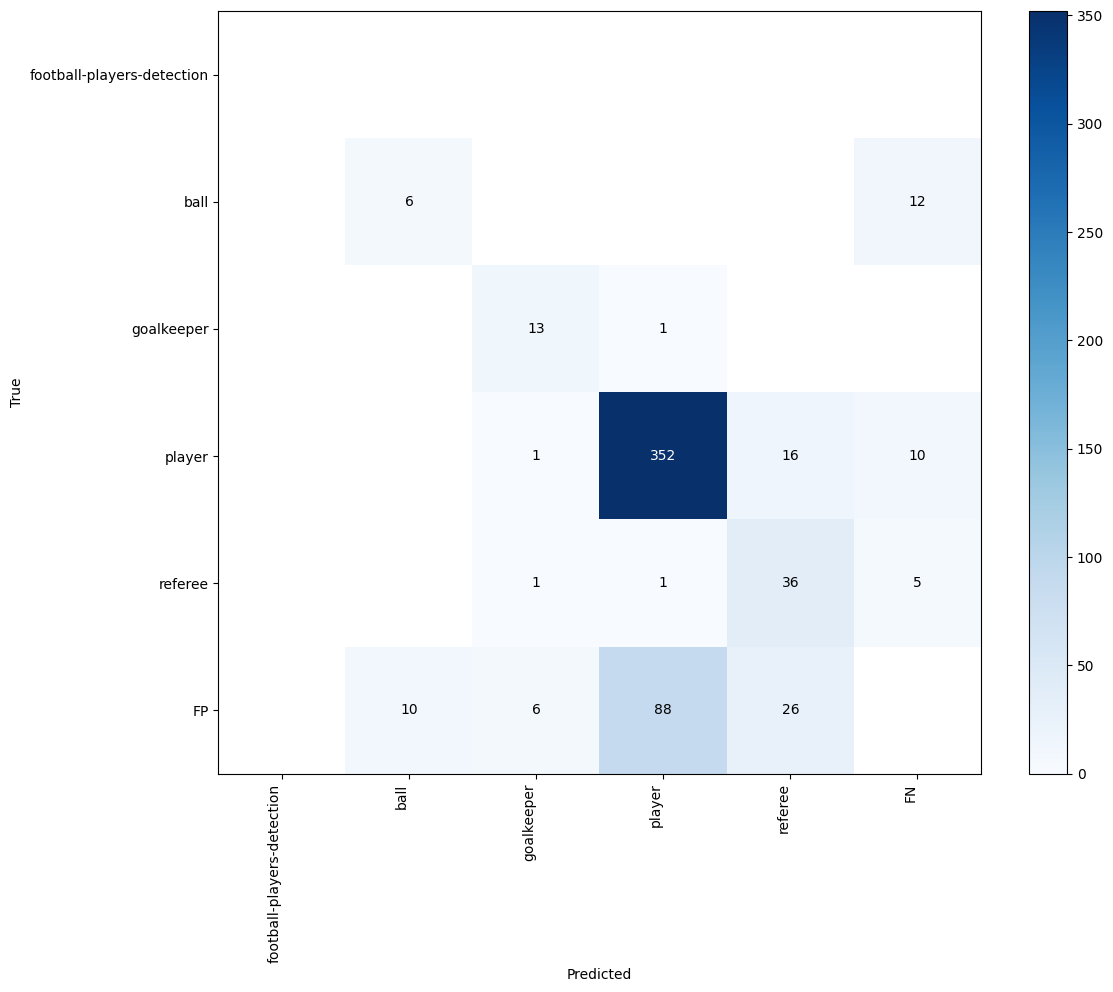

In [ ]:
#  Collect predictions

targets = []
predictions = []

for i in range(len(ds_test)):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0])

    targets.append(annotations)
    predictions.append(detections)


#  Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")



# Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds_test.classes
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [ ]:
model.save_pretrained("/content/rt-detr/")
processor.save_pretrained("/content/rt-detr/")

['/content/rt-detr/preprocessor_config.json']

## Inference with fine-tuned RT-DETR model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


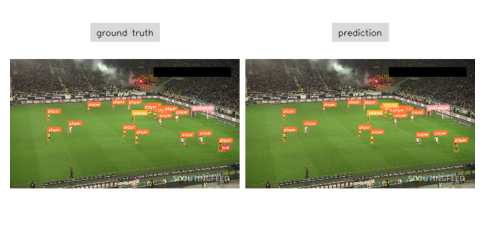

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


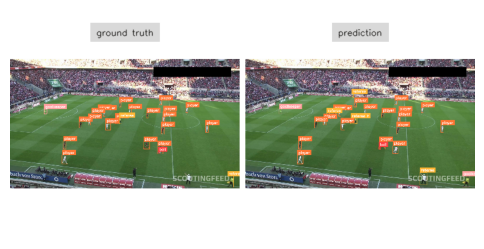

In [ ]:
IMAGE_COUNT = 2

for i in range(IMAGE_COUNT):
    path, sourece_image, annotations = ds_test[i]

    image = Image.open(path)
    inputs = processor(image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    w, h = image.size
    results = processor.post_process_object_detection(
        outputs, target_sizes=[(h, w)], threshold=0.3)

    detections = sv.Detections.from_transformers(results[0]).with_nms(threshold=0.1)

    annotated_images = [
        annotate(sourece_image, annotations, ds_train.classes),
        annotate(sourece_image, detections, ds_train.classes)
    ]
    grid = sv.create_tiles(
        annotated_images,
        titles=['ground truth', 'prediction'],
        titles_scale=0.5,
        single_tile_size=(400, 400),
        tile_padding_color=sv.Color.WHITE,
        tile_margin_color=sv.Color.WHITE
    )
    sv.plot_image(grid, size=(6, 6))

### Install YOLOv8


In [ ]:
!pip install ultralytics
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Setup complete ✅ (12 CPUs, 53.0 GB RAM, 37.0/235.7 GB disk)


## Download dataset

In [ ]:

!curl -L "https://app.roboflow.com/ds/oIqWbfRdQf?key=dTasbM67KE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1729      0 --:--:-- --:--:-- --:--:--  1729
100 44.2M  100 44.2M    0     0  9674k      0  0:00:04  0:00:04 --:--:-- 13.8M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: README.dataset.txt      
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: README.roboflow.txt     
replace data.yaml? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.yaml               
 extracting: test/images/08fd33_3_6_png.rf.da6101c00c6b22b70e7afa8c79cd64d5.jpg  
 extracting: test/images/08fd33_6_6_png.rf.f23fe4bd2b07fa644fe5f5ec99e29202.jpg  
 extracting: test/images/08fd33_9_10_png.rf.7807c329041d8326e2ee36e85309340d.jpg  
 extracting: test/images/40cd38_3_5_png.rf.92197636103741cfaad3b26b23f8c33a.jpg  
 extracting: test/imag

#Training

In [ ]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data=/content/data.yaml epochs=60 imgsz=800 plots=True

[Errno 2] No such file or directory: '{HOME}'
/content
Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

In [ ]:
!ls /content/runs/detect/train5

args.yaml					     R_curve.png	  val_batch0_labels.jpg
confusion_matrix_normalized.png			     results.csv	  val_batch0_pred.jpg
confusion_matrix.png				     results.png	  val_batch1_labels.jpg
events.out.tfevents.1728231464.d78214dfbd71.10248.0  train_batch0.jpg	  val_batch1_pred.jpg
F1_curve.png					     train_batch1.jpg	  val_batch2_labels.jpg
labels_correlogram.jpg				     train_batch2300.jpg  val_batch2_pred.jpg
labels.jpg					     train_batch2301.jpg  weights
P_curve.png					     train_batch2302.jpg
PR_curve.png					     train_batch2.jpg


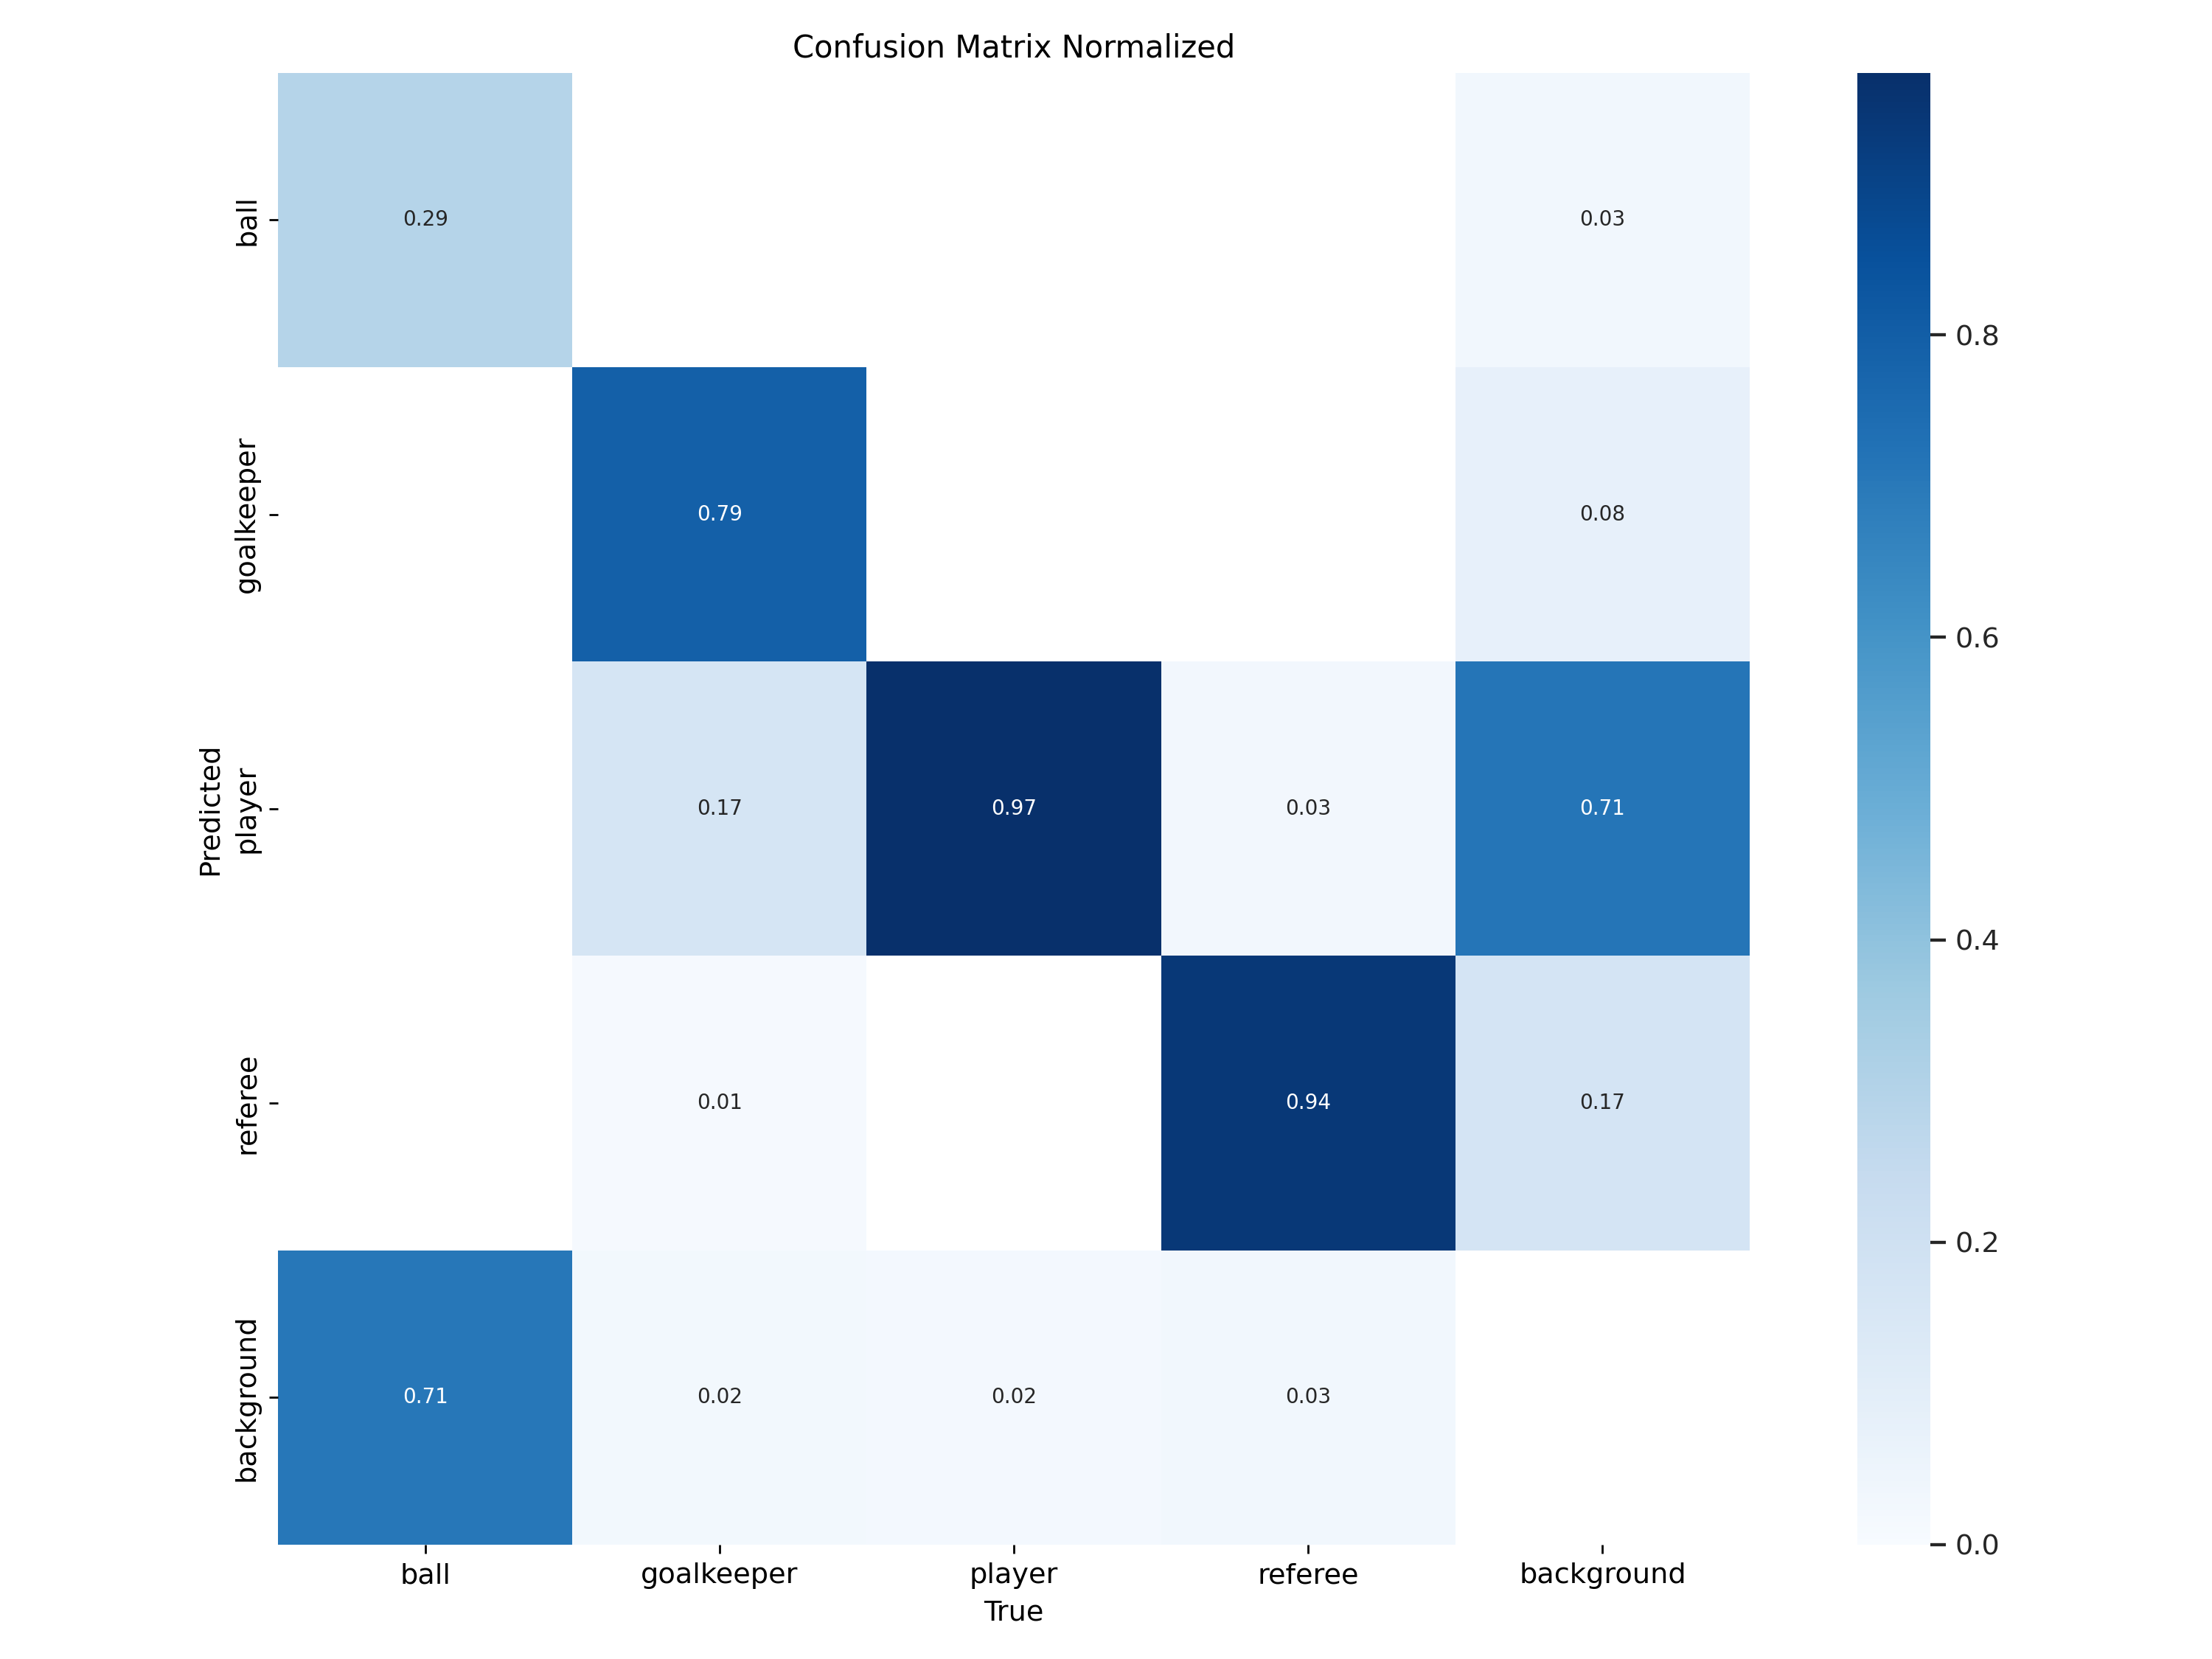

In [ ]:
from IPython.display import Image

# Define the path to the normalized confusion matrix image
image_path = '/content/runs/detect/train5/confusion_matrix_normalized.png'

# Display the image
Image(filename=image_path, width=600)


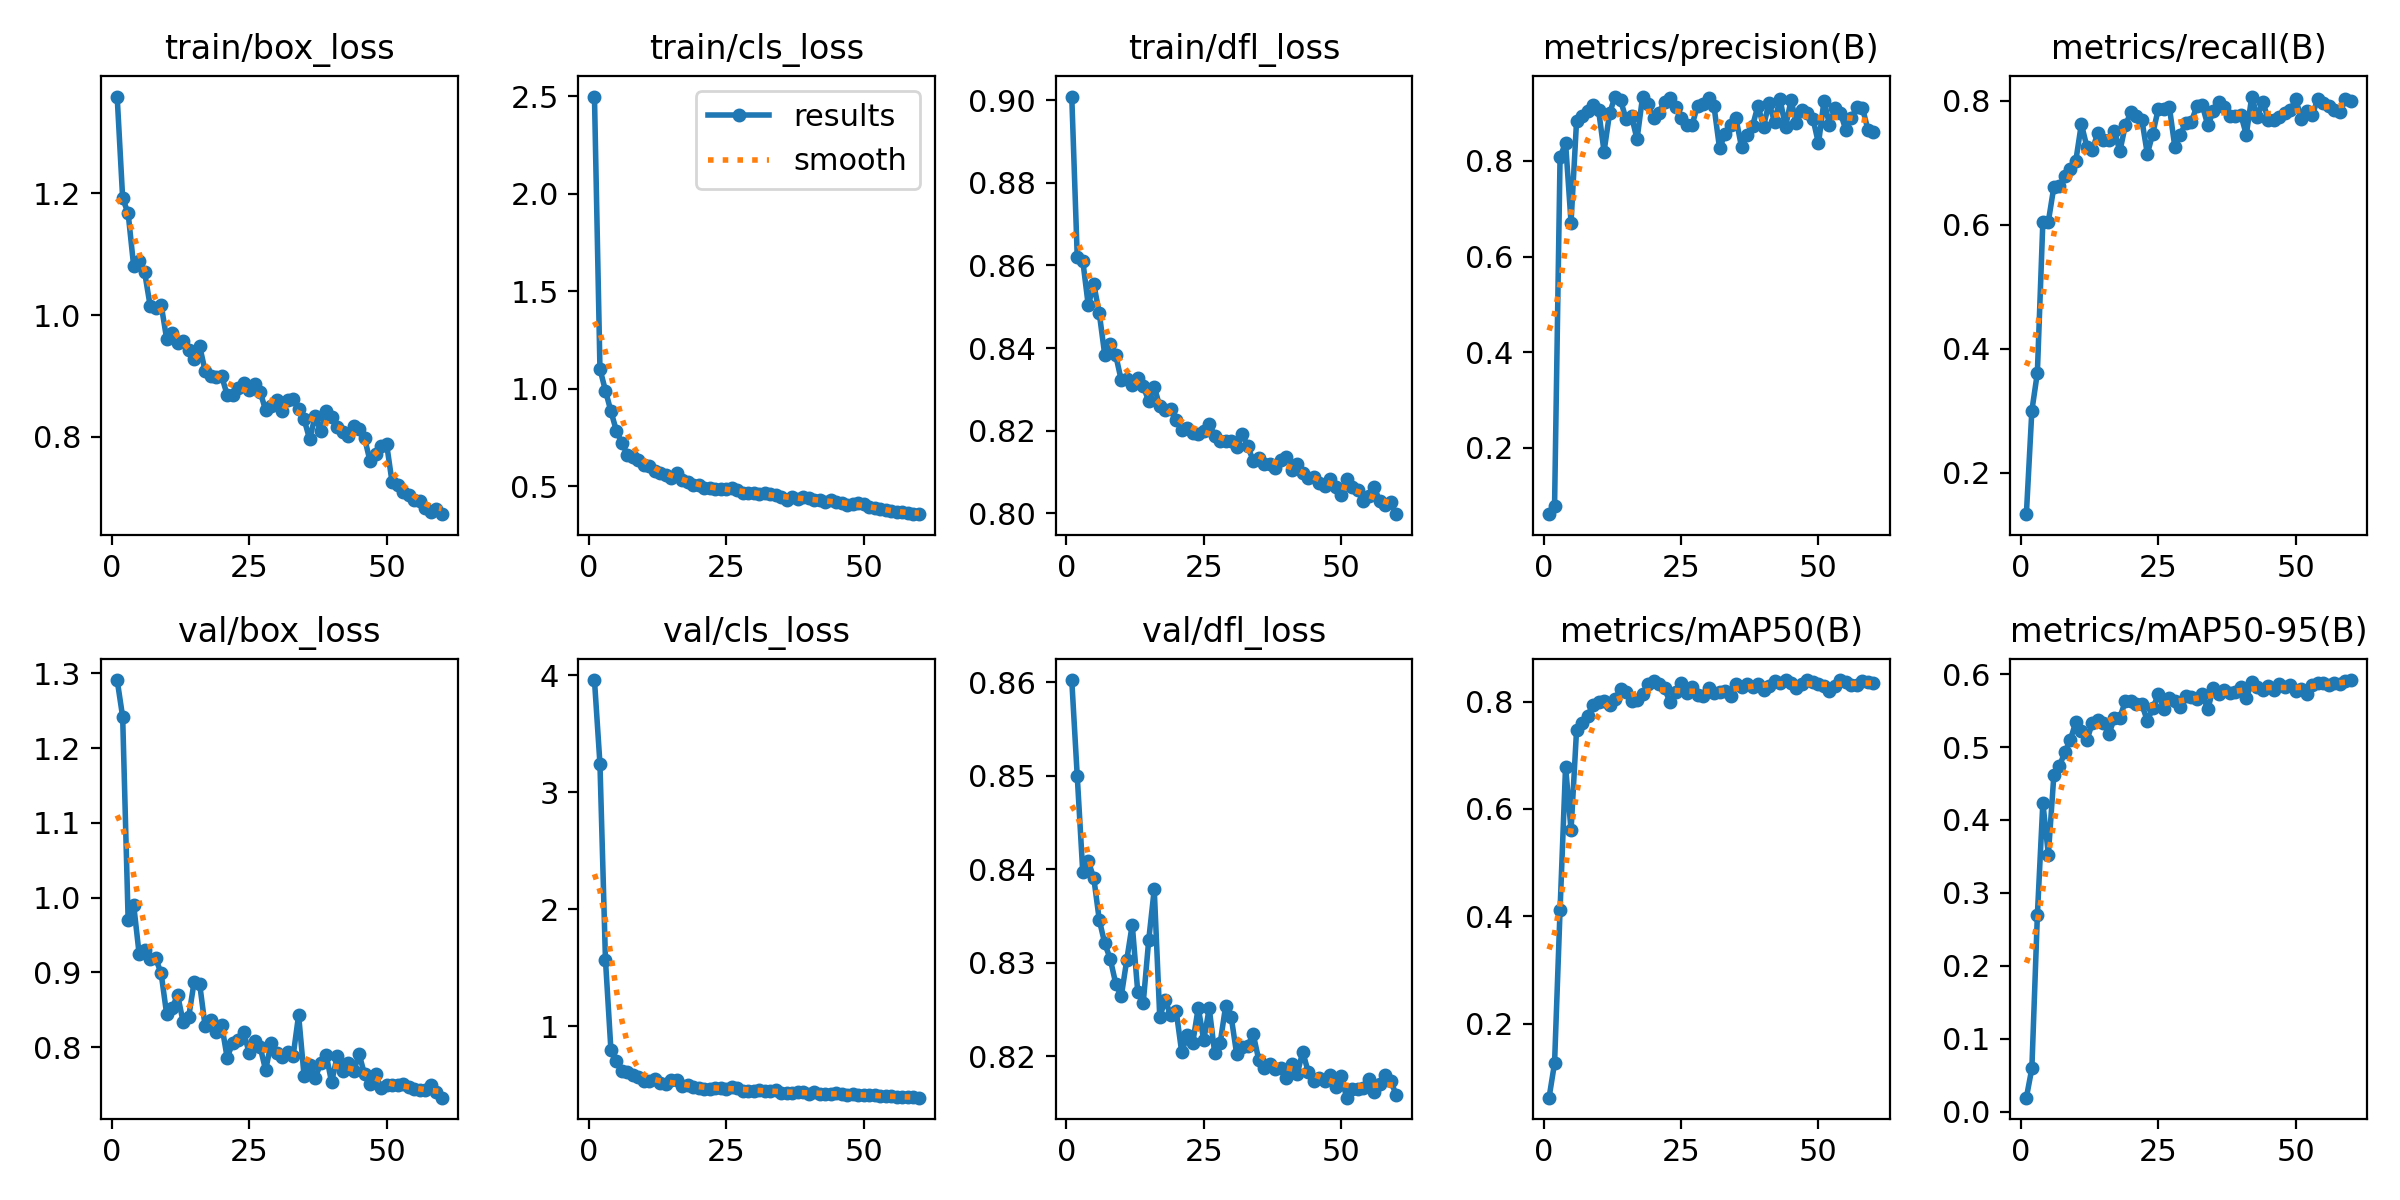

In [ ]:
# Import the Image function from IPython.display
from IPython.display import Image

# Define the path to the 'results.png' image
image_path = '/content/runs/detect/train5/results.png'

# Display the image using the defined path
Image(filename=image_path, width=600)


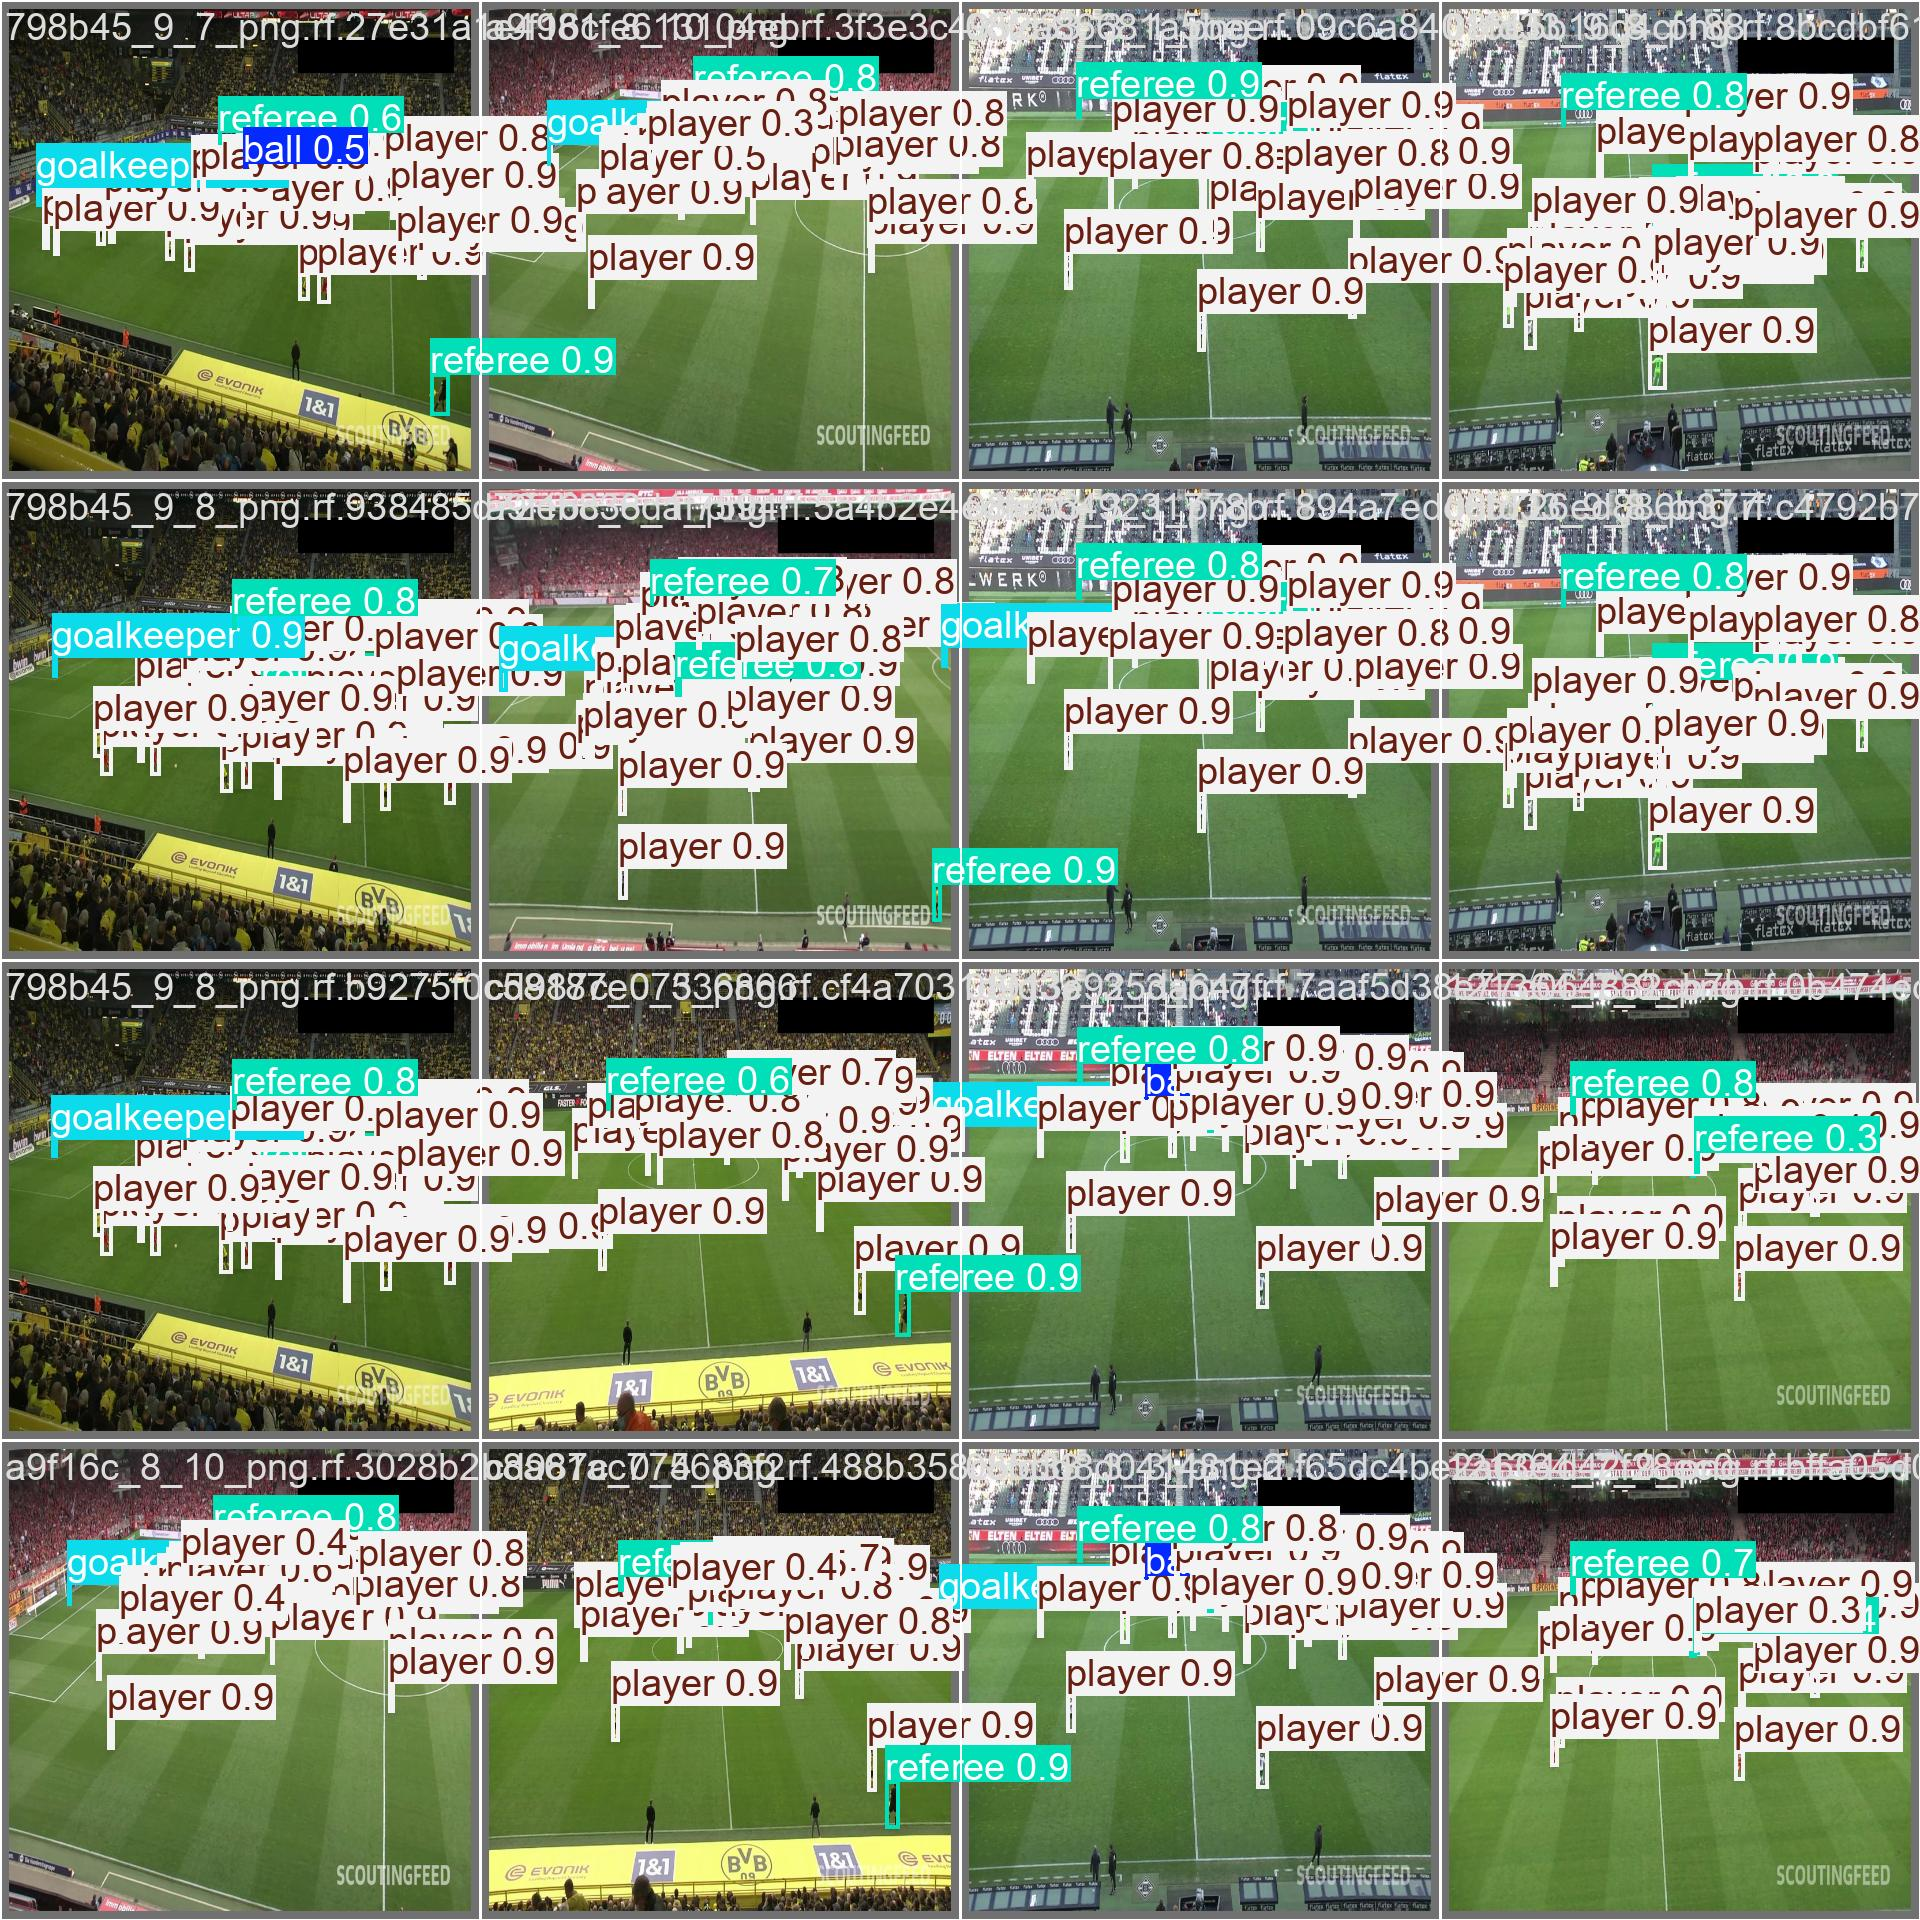

In [ ]:
# Define the path to the 'val_batch0_pred.jpg' image
image_path = '/content/runs/detect/train5/val_batch0_pred.jpg'

# Display the image
Image(filename=image_path, width=600)

# Validate Model

In [ ]:

!yolo task=detect mode=val model=/content/runs/detect/train5/weights/best.pt data=/content/data.yaml


Ultralytics 8.3.5 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA L4, 22700MiB)
Model summary (fused): 186 layers, 9,829,212 parameters, 0 gradients, 23.4 GFLOPs
val: Scanning /content/valid/labels.cache... 104 images, 0 backgrounds, 0 corrupt: 100% 104/104 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 7/7 [00:06<00:00,  1.10it/s]
                   all        104       2489      0.863      0.797      0.833        0.6
                  ball         92         92      0.741      0.348      0.444       0.18
            goalkeeper         79         82      0.882      0.902      0.941      0.723
                player        104       2067       0.94      0.984      0.992      0.814
               referee        104        248      0.889      0.956      0.957      0.685
Speed: 3.0ms preprocess, 7.2ms inference, 0.0ms loss, 39.7ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralyti

### Strengths of YOLOv8:
- **Speed**: YOLOv8 is highly optimized for real-time detection.
- **Simplicity**: The architecture is well-suited for fast and reliable detection with fewer computational resources.
- **Accuracy**: It's been fine-tuned for tasks requiring high precision, making it ideal for tracking football players during fast-paced matches.

### Strengths of Real-Time Detection Transformer (DETR):
- **Global Context**: The Transformer’s attention mechanism allows the model to understand complex relationships between objects across the entire image, potentially leading to better accuracy in detecting overlapping players.
- **End-to-End**: DETR simplifies the object detection process by eliminating the need for anchor boxes or NMS (non-maximum suppression), making it more intuitive but computationally heavier.
